In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import filters

In [2]:
df = pd.read_csv('Filtertests4.csv')
time = df.date.to_numpy().astype(np.datetime64)

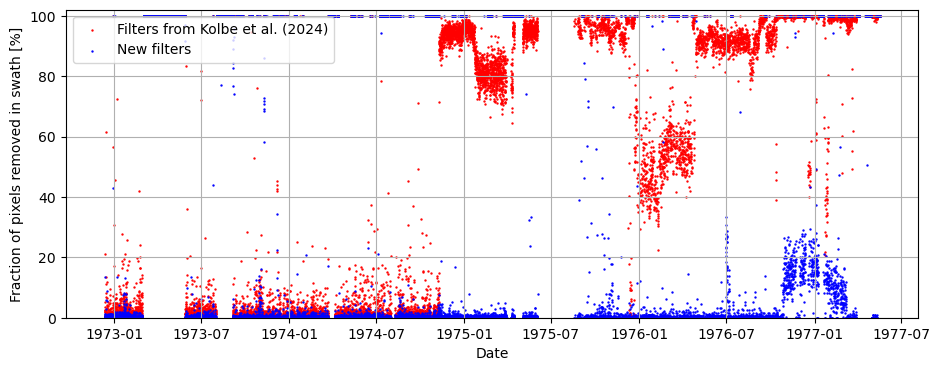

In [3]:
relchange_old = df.Rold/df['size']
relchange_old[df.Rbeam] = 1

relchange_new = df.Rnew/df['size']
relchange_new[((df['RCC1']>100) | (df['RCC2']>100))]=1

plt.figure(figsize=(11,4))
plt.scatter(time,relchange_old*100, 0.5, color='r', label='Filters from Kolbe et al. (2024)')
plt.scatter(time,relchange_new*100, 0.5, color='b', label='New filters')
plt.ylim([0,102])
plt.grid()
plt.ylabel('Fraction of pixels removed in swath [%]')
plt.xlabel('Date')

plt.legend(loc=2)
plt.savefig('RemovedData.pdf',bbox_inches='tight')


In [4]:
np.mean(relchange_new)

0.23028417519791716

In [5]:
print('Old Algorithm - all data:', np.mean(relchange_old))
print('New Algorithm - all data:', np.mean(relchange_new))

print('Old Algorithm:', np.mean(relchange_old[(relchange_old < 1)]))
print('New Algorithm:', np.mean(relchange_new[(relchange_new < 1)]))

print('Old Algorithm - before 1974-11-10:', np.mean(relchange_old[(time < np.datetime64('1974-11-10')) & (relchange_old < 1)]))
print('New Algorithm - before 1974-11-10:', np.mean(relchange_new[(time < np.datetime64('1974-11-10')) & (relchange_new < 1)]))

print('Old Algorithm - after 1974-11-10:', np.mean(relchange_old[(time > np.datetime64('1974-11-10')) & (relchange_old < 1)]))
print('New Algorithm - after 1974-11-10:', np.mean(relchange_new[(time > np.datetime64('1974-11-10')) & (relchange_new < 1)]))


Old Algorithm - all data: 0.5442162534288287
New Algorithm - all data: 0.23028417519791716
Old Algorithm: 0.40016992260121625
New Algorithm: 0.01516071563055462
Old Algorithm - before 1974-11-10: 0.02251790632196362
New Algorithm - before 1974-11-10: 0.0070153242966766605
Old Algorithm - after 1974-11-10: 0.8528827062670186
New Algorithm - after 1974-11-10: 0.024257465133470702


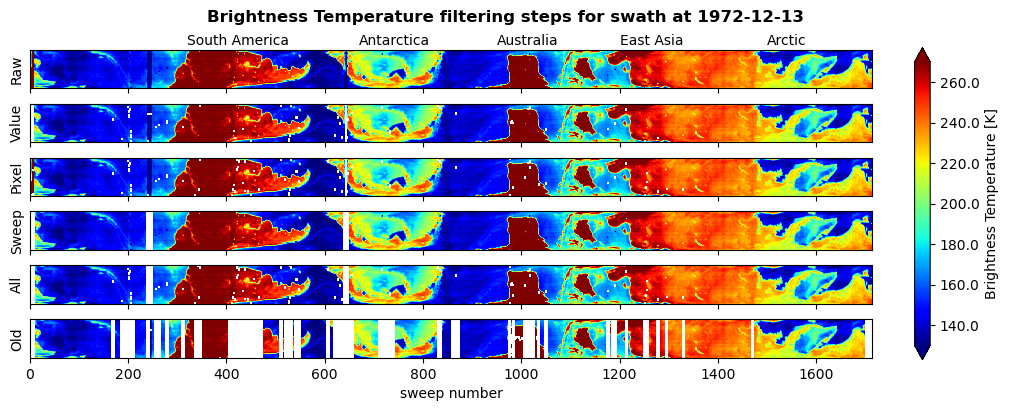

In [36]:
file = "D:/N5ESMR/ESMR_ERA5_colocated/ESMR_ERA5_coloc_1972/Nimbus5-ESMR_1972m1213t023828_DS28_era5.nc"
ds = xr.load_dataset(file)
Tb = ds['Brightness_temperature'].values


# %% Constants
MAXREPEATS = 6 #number of times a value can be repeated consecutively
MAXREPEATS_THRESH = 100 #minimum times repeat error can occur before complete removal (tolerance for above)
MINVAL = 90.0 #minimum brightness temperature value
MAXVAL = 310.0 #maximum brightness temperature value
MAX_MEDIAN_DIFFERENCE = 75 # max difference between pixel and median filtered pixel
MAX_REL_ROW_DIFFERENCE = 0.09 #maximum relative difference between two consecutive rows
MAX_REL_ROW_REPEAT_DIFFERENCE = 0.06 #Maximum relative change for zone error filter
MAX_ZONE = 25 # maximum zone width for zone filters

# Value filter
Tmask = filters.valueFilter(Tb, vmin = MINVAL, vmax=MAXVAL)
TbT = np.copy(Tb)
TbT[Tmask] = np.nan

# median filter
Pmask = filters.pixelFilter(Tb, MAX_MEDIAN_DIFFERENCE)
TbP = np.copy(Tb)
TbP[Pmask] = np.nan

# miscal filter
Mmask = filters.miscalibrationFilter(Tb, singleThreshold=MAX_REL_ROW_DIFFERENCE, pairThreshold = MAX_REL_ROW_REPEAT_DIFFERENCE, maxwidth=MAX_ZONE)
TbM = np.copy(Tb)
TbM[Mmask] = np.nan

# Zone filter
Zmask = Mmask|Pmask|Tmask
Zmask = filters.zoneFilter(Zmask, maxwidth=MAX_ZONE)
TbZ = np.copy(Tb)
TbZ[Zmask|Mmask|Pmask|Tmask] = np.nan

# Old filters
TbO = np.copy(Tb)
filters.analog_filter(ds,TbO)
filters.john_filtering(ds, TbO)


#%%
fig, ax = plt.subplots(6,1,figsize=(10,4),sharex=True,layout='constrained')

im=ax[0].imshow(Tb.T, cmap='jet',vmin=130,vmax=270)
ax[0].set_ylabel('Raw')
ax[0].text(320, -10, 'South America')
ax[0].text(670, -10, 'Antarctica')
ax[0].text(950, -10, 'Australia')
ax[0].text(1200, -10, 'East Asia')
ax[0].text(1500, -10, 'Arctic')

ax[1].imshow(TbT.T, cmap='jet',vmin=130,vmax=270)
ax[1].set_ylabel('Value')

ax[2].imshow(TbP.T, cmap='jet',vmin=130,vmax=270)
ax[2].set_ylabel('Pixel')

ax[3].imshow(TbM.T, cmap='jet',vmin=130,vmax=270)
ax[3].set_ylabel('Sweep')

ax[4].imshow(TbZ.T, cmap='jet',vmin=130,vmax=270)
ax[4].set_ylabel('All')

ax[5].imshow(TbO.T, cmap='jet',vmin=130,vmax=270)
ax[5].set_ylabel('Old')
for axs in ax:
    axs.set_yticks([])
    #axs.set_xticks([])
ax[5].set_xlabel('sweep number')

fig.suptitle('Brightness Temperature filtering steps for swath at 1972-12-13', fontsize=12, fontweight='bold')
fig.colorbar(im, ax=ax.ravel().tolist(),format='%.1f',label = 'Brightness Temperature [K]',extend='both')
plt.savefig('Filters.pdf',bbox_inches='tight')

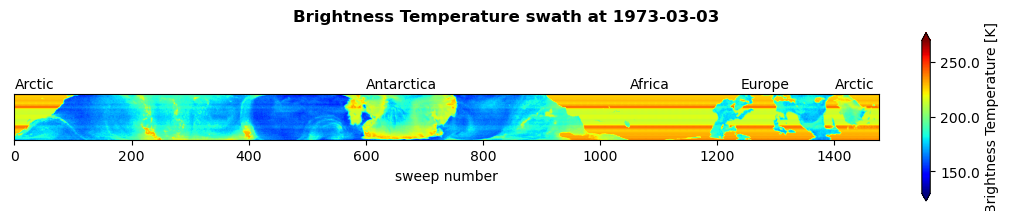

In [43]:
file = 'D:/N5ESMR/ESMR_ERA5_colocated/ESMR_ERA5_coloc_1973/Nimbus5-ESMR_1973m0303t081945_DS34_era5.nc'
ds = xr.load_dataset(file)
Tb = ds['Brightness_temperature'].values


fig, ax = plt.subplots(1,1,figsize=(10,2),layout='constrained')
im=ax.imshow(Tb.T, cmap='jet',vmin=130,vmax=270)

ax.text(0, -10, 'Arctic')
ax.text(600, -10, 'Antarctica')
ax.text(1050, -10, 'Africa')
ax.text(1240, -10, 'Europe')
ax.text(1400, -10, 'Arctic')
ax.set_yticks([])
#ax.set_xticks([])
fig.suptitle('Brightness Temperature swath at 1973-03-03', fontsize=12, fontweight='bold')
ax.set_xlabel('sweep number')
fig.colorbar(im, ax=ax,format='%.1f',label = 'Brightness Temperature [K]',extend='both')
plt.savefig('badOrbit.pdf',bbox_inches='tight')

In [8]:
def esmrLUT():
    slopeA=np.array([1.058,1.027,0.99,0.98,0.963,0.987,0.97,0.961,0.969,0.98,0.98,1.018,0.999,\
                 0.989,0.975,0.974,0.994,1.026,1.038,1.018,1.034,1.099,1.082,1.048,0.986,0.960,\
                 0.941,0.947,0.937,0.942,0.963,1.003,1.002,0.976,0.988,1.004,1.000,1.00,1.00,1.00,1.00,1.00,1.002,\
                 0.962,0.96,0.98,0.966,0.966,0.948,0.949,0.934,0.945,0.988,1.019,1.041,1.049,1.042,\
                 1.019,1.015,1.012,0.993,0.976,0.998,0.983,0.998,0.970,0.982,0.980,0.955,0.974,0.941,\
                 0.969,0.949,0.967,0.956,0.959,0.969,1.030])
    offsetB=np.array([4,10,16,14,17,15,17,19,18,16,17,10,12,13,15,15,10,8,5,13,13,4,9,8,12,10,\
                 11,10,11,10,6,-3,-3,1,-1,0,0,0,0,0,0,0,-3,4,4,2,4,6,10,10,12,13,11,11,11,14,15,\
                 16,15,12,13,15,12,14,14,19,18,19,\
                 24,22,26,22,30,22,27,28,26,13])
    return slopeA, offsetB

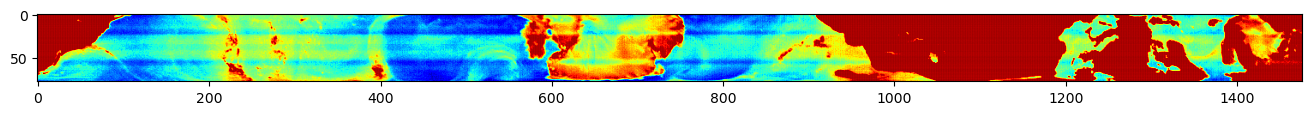

In [9]:
A,B = esmrLUT()
Tb_def = (Tb - B[None,:])/A[None,:]
fig, ax = plt.subplots(1,1,figsize=(13,2),layout='constrained')
im=ax.imshow(Tb_def.T, cmap='jet',vmin=130,vmax=220)

In [10]:
out = filters.constColumnFilter(Tb, 6, ReplaceEntireRow=False,separation=2)

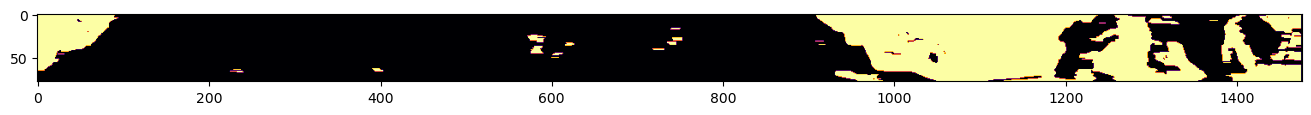

In [11]:
fig, ax = plt.subplots(1,1,figsize=(13,2),layout='constrained')
im=ax.imshow(out.T, cmap='inferno')